In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [ ]:
class LMF(nn.Module):
  def __init__(self, input_dims: dict, output_dim: int, rank: int, use_bias: bool = True):
    super(LMF,self).__init__()
    if not isinstance(input_dims, dict) or not input_dims:
      raise ValueError("inputs dms must not be an empty dictionary")
    if not all(isinstance(dim,int) and dim>0 for dim in input_dims.values()):
      raise ValueError("inputs must be positive integers")
    if not isinstance(output_dim, int) or output_dim<=0:
      raise ValueError("output_dim must be a positive integer")
    if not isinstance(rank, int) or rank<=0:
      raise ValueError("rank must be a positive integer")
    self.input_dims = input_dims
    self.output_dim = output_dim
    self.rank = rank
    self.use_bias = use_bias
    self.modalities = list(input_dims.keys())

    self.modality_factors = nn.ModuleDict({
        modality : nn.Linear(dim+1, rank * output_dim, bias=False)
        for modality , dim in input_dims.items()
    })

    self.pred_layer = nn.Linear(rank, output_dim, bias=self.use_bias)

  def forward(self, multimodal_data:dict) -> torch.Tensor:
    if not isinstance(multimodal_data, dict) or set(multimodal_data.keys()) != set(self.modalities):
      raise ValueError("The keys in multimodal_data must match the modalities provided during initialization.")
    batch_size = next(iter(multimodal_data.values())).size(0)
    ones = torch.ones(batch_size, 1, device = next(self.parameters()).device)
    projected_modalities = {}
    for modality , data in multimodal_data.items():
      data_with_one = torch.cat((data,ones),dim=1)
      projected = self.modality_factors[modality](data_with_one)
      projected_modalities[modality] = projected.view(batch_size, self.rank, self.output_dim)

    fused_representation = torch.ones_like(projected_modalities[self.modalities[0]])
    for modality in self.modalities:
      fused_representation = fused_representation*projected_modalities[modality]

    output = self.pred_layer(fused_representation.permute(0,2,1))

    return output.squeeze(-1)

In [ ]:
def test_lmf_model(model, dummy_data, dummy_labels):
  print("\n--- Testing Model ---")

  predictions = model(dummy_data)

  print(f"Input batch size: {next(iter(dummy_data.values())).size(0)}")
  print(f"Output prediction shape: {predictions.shape}")

  assert predictions.shape == dummy_labels.shape
  print("Forward Pass successful")

  #Backward Pass

  optimizer = optim.Adam(model.parameters())
  loss_fn = nn.MSELoss()
  optimizer.zero_grad()
  loss = loss_fn(predictions, dummy_labels)
  loss.backward()
  optimizer.step()

  print("Backward Pass Successful")
  print("Model Testing Complete")

In [ ]:
def plot_training_loss(losses):
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.title('Training Loss vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

LMF(
  (modality_factors): ModuleDict(
    (visual): Linear(in_features=129, out_features=4, bias=False)
    (audio): Linear(in_features=65, out_features=4, bias=False)
    (text): Linear(in_features=301, out_features=4, bias=False)
  )
  (pred_layer): Linear(in_features=4, out_features=1, bias=True)
)

Total Trainable Parameters 1985

--- Testing Model ---
Input batch size: 32
Output prediction shape: torch.Size([32, 1])
Forward Pass successful
Backward Pass Successful
Model Testing Complete

--Running a simple training example---
Epoch [1/20], Loss: 1.4896
Epoch [2/20], Loss: 1.4135
Epoch [3/20], Loss: 1.3392
Epoch [4/20], Loss: 1.2661
Epoch [5/20], Loss: 1.1938
Epoch [6/20], Loss: 1.1219
Epoch [7/20], Loss: 1.0497
Epoch [8/20], Loss: 0.9764
Epoch [9/20], Loss: 0.9016
Epoch [10/20], Loss: 0.8254
Epoch [11/20], Loss: 0.7485
Epoch [12/20], Loss: 0.6731
Epoch [13/20], Loss: 0.6020
Epoch [14/20], Loss: 0.5386
Epoch [15/20], Loss: 0.4861
Epoch [16/20], Loss: 0.4465
Epoch [17/20], Loss: 0.

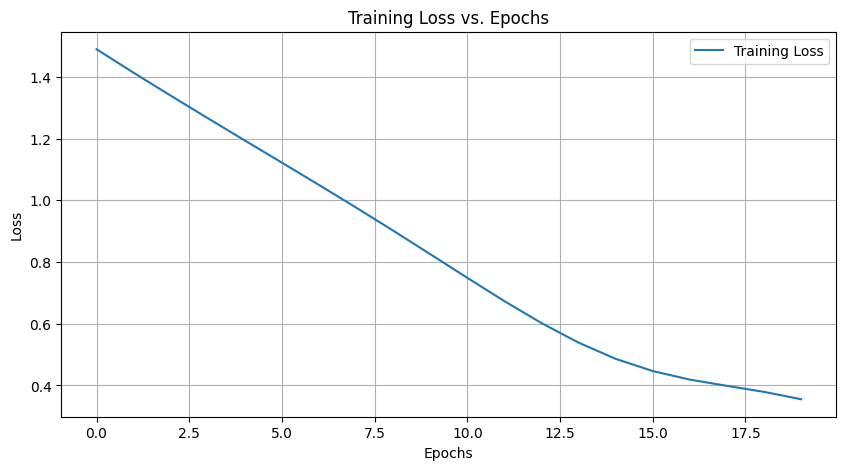

In [ ]:
if __name__  == "__main__":
  input_dimensions = {
        'visual': 128,  # e.g., features from a CNN
        'audio': 64,    # e.g., features from an audio model
        'text': 300     # e.g., features from a language model
        }
  output_dimension = 1 #regression
  fusion_rank = 4 #fusion rank

  lmf_model = LMF(input_dimensions, output_dimension, fusion_rank)
  print(lmf_model)

  num_params = sum(p.numel() for p in lmf_model.parameters() if p.requires_grad)
  print(f"\nTotal Trainable Parameters {num_params}")

  batch_size = 32
  dummy_data = {
        'visual': torch.randn(batch_size, input_dimensions['visual']),
        'audio': torch.randn(batch_size, input_dimensions['audio']),
        'text': torch.randn(batch_size, input_dimensions['text'])
    }
  dummy_labels = torch.randn(batch_size, output_dimension)

  test_lmf_model(lmf_model, dummy_data, dummy_labels)

  print("\n--Running a simple training example---")
  optimizer = optim.Adam(lmf_model.parameters(), lr=0.001)
  loss_fn = nn.MSELoss()
  num_epochs = 20
  epoch_losses = []
  for epoch in range(num_epochs):
        optimizer.zero_grad()
        predictions = lmf_model(dummy_data)
        loss = loss_fn(predictions, dummy_labels)
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")
  print("\nTraining example completed successfully.")
  print("\n--- Visualizing Training Loss ---")
  plot_training_loss(epoch_losses)